# Use kernel `qgraph`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import cmath
from scipy.integrate import solve_ivp

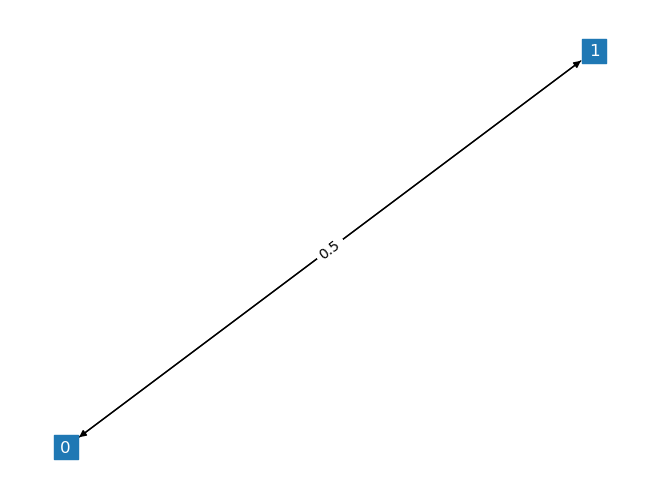

In [17]:
#Testing out making a graph with weighted edges with nx



def makeGraphWithWeightedEdges(edgelist, weightlist=0):
    ''' 
    edgelist = list with tupes of the form (n, m)
    weightlist = list of floats where the size of the list is the same as the size of the edgelist
    '''
    if weightlist == 0:
        G = nx.DiGraph(edgelist)
    if len(weightlist) != len(edgelist):
        return "Error, weightlist is not same size as edgelist"
    else:
        G = nx.DiGraph()
        i = 0
        for edge in edgelist:
            G.add_edge(edge[0], edge[1], weight = weightlist[i])
            i+=1
    return G

#I have stolen this code from https://transport-systems.imperial.ac.uk/tf/60008_21/n2_2_weighted_and_directed_graphs
def show_wgraph(G):
    plt.figure()    
    pos = nx.spring_layout(G)
    weight_labels = nx.get_edge_attributes(G,'weight')
    nx.draw(G,pos,font_color = 'white', node_shape = 's', with_labels = True,)
    output = nx.draw_networkx_edge_labels(G,pos,edge_labels=weight_labels)

#An example to test
#Graph = makeGraphWithWeightedEdges([(0, 1), (2, 1), (0, 2)], [0.5, 0.5, 0.2])
#show_wgraph(Graph)

A = np.matrix([[0, 0.5], [0.5, 0]])
G = nx.from_numpy_array(A, create_using = nx.DiGraph())
show_wgraph(G)


#Lattice ex







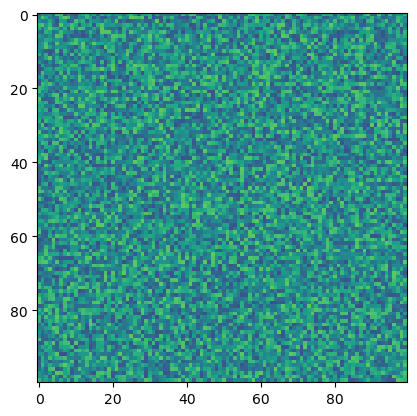

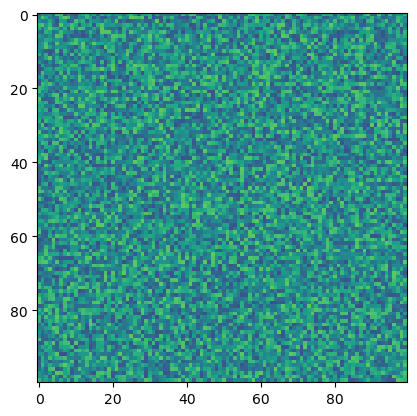

In [18]:
j = complex(0, 1)

class SchroOnLattice:
    """
    An implementation of the Allen-Cahn equation in two dimensions, using the method
    of lines and explicit finite differences

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        kappa (float): reaction rate
        d (float): diffusion coefficient
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction

    """

    def __init__(self, nx, ny, V = [0], m = 1.0, hbar = 1e-10, Lx = 1.0, Ly=1.0):
        self.nx = nx
        self.ny = ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.m = m
        self.hbar = hbar
        if len(V) == 1:
            self.V = np.full((self.nx, self.ny), V)
        else: 
            self.V = V
            

        
       
    def _laplace(self, grid):
        """
        Apply the two-dimensional Laplace operator to a square array
        """
        ################################################################################
        #
        #
        #  YOUR CODE HERE
        #  My 10 line solution is vectorized in numpy, and so it avoids using a for loop 
        #  There are several valid ways to implement the boundary conditions
        #
        ################################################################################
        
        #lap = np.zeros_like(grid)
        #lap[1:-1] = (grid[:-2, 1:-1] + grid[2:, 1:-1] - 2 * grid[1:-1, 1:-1]) / self.dx**2
        #lap[1:-1] += (grid[1:-1, :-2] + grid[1:-1, 2:] - 2 * grid[1:-1, 1:-1]) / self.dy**2
        
        padded = np.pad(grid, ((1, 1), (1, 1)), "symmetric")

        # Add up the four nearest neighbors and subtract 4 times the center
        lap = padded[1:-1, 2:] + padded[1:-1, :-2] + \
            padded[2:, 1:-1] + padded[:-2, 1:-1] - 4 * padded[1:-1, 1:-1]
        
        return lap / (self.dx * self.dy)
        
        for i in range(self.nx):
            for j in range(self.ny):
                if not(i == 0 or j == 0 or i == self.nx - 1 or j == self.ny - 1):
                    lap[i, j] = grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                    
                lap[i, j] = lap[i, j] - grid[i, j] * 4
            
        return lap / (self.dx * self.dy)

        # Reflection boundary conditions
        lap[:, 0] = lap[:, 1]
        lap[:, -1] = lap[:, -2]
        lap[0, :] = lap[1, :]
        lap[-1, :] = lap[-2, :]

        return lap

    def _potential(self, grid):
        """
        Bistable reaction term
        """
        pot = self.V * grid

        return pot

    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        ################################################################################
        #
        #
        #  YOUR CODE HERE
        #  My solution primariy calls private methods
        #
        #
        ################################################################################
        y = y.reshape((self.nx, self.ny))
        lapcoeff = j*self.hbar/(2*self.m)
        out = (-1*j/self.hbar) * self._potential(y) + lapcoeff * self._laplace(y)
        return out.flatten()


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the odeint solver

        **kwargs are passed to scipy.integrate.solve_ivp
        """
        ################################################################################
        #
        #
        #  YOUR CODE HERE
        #  My solution is five lines, and it mainly involves setting things up to be
        #  passed to scipy.integrate.solve_ivp, and then returning the results
        #
        #
        ################################################################################
        tpts = np.linspace(t_min, t_max, nt)
        out = solve_ivp(self.rhs, (t_min, t_max), y0.flatten(), t_eval=tpts, **kwargs)
        sol = out.y.T
        tpts =  out.t
        return tpts, sol.reshape((len(tpts), self.nx, self.ny))
    
ic = np.random.random((100, 100)) - 0.5
model = SchroOnLattice(*ic.shape)
tpts, sol = model.solve(ic, 0, 20, 400, method="DOP853")

plt.figure()
plt.imshow(sol[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol[-1], vmin=-1, vmax=1)

